In [1]:
#clone source code Yolov7 
%cd /content/drive/MyDrive
!git clone https://github.com/WongKinYiu/yolov7

/content/drive/MyDrive
fatal: destination path 'yolov7' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/MyDrive/yolov7
!pip install -r requirements.txt

# Xử lý xoay ảnh 

In [3]:
import cv2
import torch
import numpy as np
import os

from models.experimental import attempt_load
from utils.datasets import letterbox
from utils.general import non_max_suppression, scale_coords
from utils.plots import plot_one_box

device = torch.device("cuda:0")
half = device.type != "cpu"

CATEGORIES = ["bottom_left","bottom_right", "top_left", "top_right"]
COLORS = [(66, 135, 245), (194, 66, 245), (250, 52, 72), (111, 250, 52)]


def load_model(path):
    model = attempt_load(path, map_location=device)

    if half:
        model.half() 
    #model = torch.load(path, map_location=torch.device('cpu'))

    return model


def convert_img(img, device, half, new_size=416):
    img = letterbox(img, new_shape=new_size)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)

    img = img.half() if half else img.float()
    img = img / 255.0

    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    return img


def predict_4_corners(img, model, resized_width=640):
    if resized_width is not None:
        orig_img = cv2.resize(img, width=640)
    else:
        orig_img = cv2.imread(img).copy()

    plot_img = orig_img.copy()
    img = convert_img(orig_img, device, half, new_size=640)
    _, _, new_height, new_width = img.size()

    preds = model(img)[0]
    preds = non_max_suppression(preds, 0.2, 0.2)
    result = np.array([], dtype=np.float32)

    # based on YOLOv7
    for i, det in enumerate(preds):  # detections per image
        if det is not None:
            # Rescale boxes from img_size to im0 sizes
            det[:, :4] = scale_coords(img.size()[2:], det[:, :4], orig_img.shape).round()
            result = det.type(torch.float32).cpu().detach().numpy()

            # for visualization only
            for *xyxy, conf, cls in reversed(det):
                label = '%s %.2f' % (CATEGORIES[int(cls)], conf)
                plot_one_box(xyxy, plot_img, label=label, color=COLORS[int(cls)], line_thickness=2)

    return result, orig_img, plot_img


def filter_redundancy(result):
    deleted_indexes = []

    for i, element in enumerate(result):
        category = element[5]
        max_class_confidence_score = max(result[np.where(result[:, 5] == category)][:, 4])

        if element[4] < max_class_confidence_score:
            deleted_indexes.append(i)

    return np.delete(result, deleted_indexes, axis=0)


def get_center_point(coordinate_dict):
    di = dict()

    for key in coordinate_dict.keys():
        xmin, ymin, xmax, ymax = coordinate_dict[key]
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        di[key] = (x_center, y_center)

    return di

def get_point(coordinate_dict):
    di = dict()

    for key in coordinate_dict.keys():
        xmin, ymin, xmax, ymax = coordinate_dict[key]
        if key == 'bottom_left':
          di[key] = (xmin, ymin + 50)
        elif key == 'bottom_right':
          di[key] = (xmax, ymin + 50)
        elif key == 'top_left':
          di[key] = (xmin, ymax - 25)
        elif key == 'top_right':
          di[key] = (xmax, ymax - 25)

    return di


def dictionary(result):
    diction = {}
    for det in result:
        if int(det[5]) == 0:
              a = 'bottom_left'
        elif int(det[5]) == 1:
              a = 'bottom_right'
        elif int(det[5]) == 2:
              a = 'top_left'
        elif int(det[5]) == 3:
              a = 'top_right'      
        label = [
            det[0], 
            det[1], 
            det[2], 
            det[3],         
        ]
        diction[a] = label

    return diction

def find_miss_corner(coordinate_dict):
    position_name = ['bottom_left', 'bottom_right','top_left', 'top_right']
    position_index = np.array([0, 0, 0, 0])

    for name in coordinate_dict.keys():
        if name in position_name:
            position_index[position_name.index(name)] = 1

    index = np.argmin(position_index)

    return index


def calculate_missed_coord_corner(coordinate_dict):
    thresh = 0

    index = find_miss_corner(coordinate_dict)

    # calculate missed corner coordinate
    # case 1: missed corner is "top_left"
    
    if index == 0:  # "bottom_left"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_right'][0] - thresh
        coordinate_dict['bottom_left'] = (x, y)
    elif index == 1:  # "bottom_right"
        midpoint = np.add(coordinate_dict['bottom_left'], coordinate_dict['top_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_left'][0] - thresh
        coordinate_dict['bottom_right'] = (x, y)
    elif index == 2:
        midpoint = np.add(coordinate_dict['top_right'], coordinate_dict['bottom_left']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_right'][0] - thresh
        coordinate_dict['top_left'] = (x, y)
    elif index == 3:  # "top_right"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_left'][0] - thresh
        coordinate_dict['top_right'] = (x, y)
    return coordinate_dict


def perspective_transform(image, source_points):
    dest_points = np.float32([[0, 0], [500, 0], [500, 300], [0, 300]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (500, 300))

    return dst



def warp_identity_card(img, model):
    
    result, orig_img, plot_img = predict_4_corners(img, model, None)
    if len(result) > 4:
        result = filter_redundancy(result)

    result = dictionary(result)        
    result = get_point(result) 

    if len(result) < 3:
        print('Please try again')
        return plot_img
    
    if len(result) == 3:
        result = calculate_missed_coord_corner(result)   

    bottom_right_point = result['bottom_right']
    bottom_left_point = result['bottom_left']
    top_left_point = result['top_left']
    top_right_point = result['top_right']

    source_points = np.float32([top_left_point,top_right_point,bottom_right_point,bottom_left_point])
    #img = cv2.imread(orig_img)
    crop = perspective_transform(orig_img, source_points)

    return crop


/content/drive/MyDrive/yolov7
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


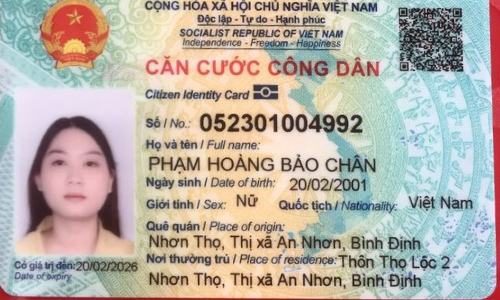

In [24]:
%cd /content/drive/MyDrive/yolov7
#from corner_detection import predict_4_corners, load_model, filter_redundancy
import glob
import os
from google.colab.patches import cv2_imshow
import numpy as np

if __name__ == "__main__":
    model = load_model("/content/drive/MyDrive/best_conner.pt")

    img_paths = glob.glob("/content/drive/MyDrive/cccd_chip/49.jpg")
    img_paths = list(filter(lambda img_path: not os.path.exists(img_path.replace(".jpg", ".txt")), img_paths))

    for img_path in img_paths:
        img_name = img_path.split("/")[-1].split(".")[0]
        
        crop = warp_identity_card(img_path, model)
       
        cv2_imshow(crop)  


# Xử lý các thông tin bên trong

In [5]:
categories_text = ['id', 'name', 'birth', 'sex', 'nation', 'origin', 'origin1', 'r1', 'r2']

def predict_text(img, model, resized_width=640):
    if resized_width is not None:
        orig_img = cv2.resize(img, width=640)
    else:
        orig_img = cv2.imread(img).copy()

    plot_img = orig_img.copy()
    img = convert_img(orig_img, device, half, new_size=640)
    _, _, new_height, new_width = img.size()

    preds = model(img)[0]
    preds = non_max_suppression(preds, 0.2, 0.2)
    result = np.array([], dtype=np.float32)

    # based on YOLOv7
    for i, det in enumerate(preds):  # detections per image
        if det is not None:
            # Rescale boxes from img_size to im0 sizes
            det[:, :4] = scale_coords(img.size()[2:], det[:, :4], orig_img.shape).round()
            result = det.type(torch.float32).cpu().detach().numpy()

            # for visualization only
           #for *xyxy, conf, cls in reversed(det):
               # label = '%s %.2f' % (CATEGORIES[int(cls)], conf)
                #plot_one_box(xyxy, plot_img, label=label, color=COLORS[int(cls)], line_thickness=2) '''

    return result, orig_img, plot_img

def dictionary_text(result):
    diction = {}
    for det in result:
        if int(det[5]) == 0:
              a = 'birth'
        elif int(det[5]) == 1:
              a = 'id'
        elif int(det[5]) == 2:
              a = 'name'
        elif int(det[5]) == 3:
              a = 'nation'      
        elif int(det[5]) == 4:
              a = 'origin'  
        elif int(det[5]) == 5:
              a = 'origin1'  
        elif int(det[5]) == 6:
              a = 'r1'  
        elif int(det[5]) == 7:
              a = 'r2'  
        elif int(det[5]) == 8:
              a = 'sex'  
        label = [
            det[0], 
            det[1],
            det[2], 
            det[3]      
        ]
        diction[a] = label

    return diction

def perspective_transform_text(image, source_points):
    dest_points = np.float32([[0, 0], [800, 0], [800, 100], [0, 100]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (800, 100))

    return dst

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


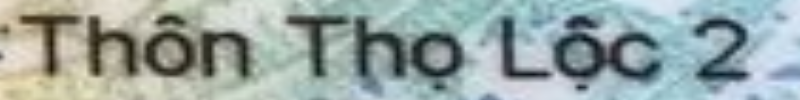

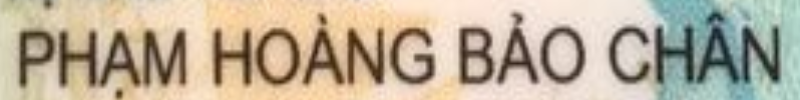

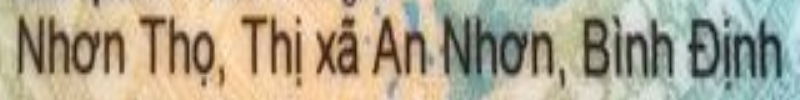

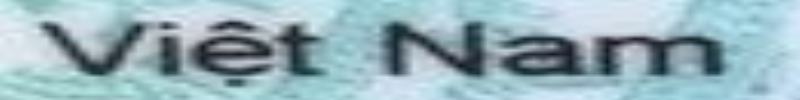

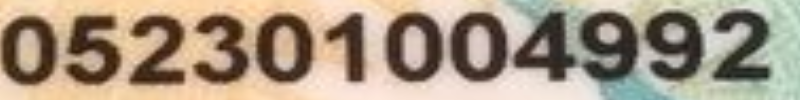

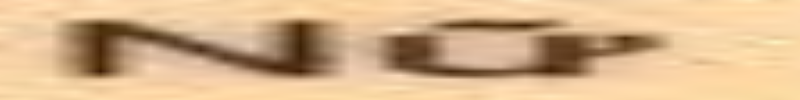

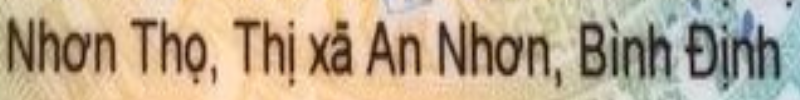

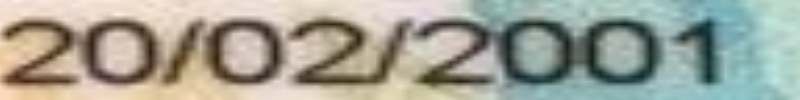

dict_keys(['r1', 'name', 'origin', 'nation', 'id', 'sex', 'r2', 'birth'])


In [25]:
model_text = load_model("/content/drive/MyDrive/best_text.pt")
dir = '/content/drive/MyDrive/ocr'
for img_path in img_paths:
    img_name = img_path.split("/")[-1].split(".")[0]
    result, orig_img, plot_img = predict_text(img_path, model_text, None)
    result = dictionary_text(result)

    for key in result.keys():
        xmin, ymin, xmax, ymax = result[key]

        bottom_right_point = (xmax, ymin)
        bottom_left_point = (xmin, ymin)
        top_left_point = (xmin, ymax)
        top_right_point = (xmax, ymax)

        source_points = np.float32([bottom_left_point,bottom_right_point, top_right_point,top_left_point]) 
        crop = perspective_transform_text(orig_img, source_points)
        cv2_imshow(crop)
        #cv2.imwrite(f"{dir}/" + img_name + key + ".jpg", crop)

        #img = Image.fromarray(crop)
        #plt.imshow(img)
        #s = detector.predict(img)
        #print(key + ':' + s) 

    print(result.keys())

# Vietocr

In [ ]:
!pip install --quiet vietocr

%cd /content/drive/MyDrive
!git clone https://github.com/pbcquoc/vietocr.git

!pip install --quiet vietocr==0.3.2
!pip install torch
!pip install torchvision

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [21]:
config = Cfg.load_config_from_name('vgg_transformer')

In [22]:
%cd /content/drive/MyDrive/vietocr
config['weights'] = '/content/drive/MyDrive/vietocr/weights/transformerocr.pth'
#config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
config['cnn']['pretrained']=False
config['device'] = 'cuda:0'
config['predictor']['beamsearch']=False
detector = Predictor(config)

/content/drive/MyDrive/vietocr


In [23]:
#%cd /content/drive/MyDrive/yolov7
#from corner_detection import predict_4_corners, load_model, filter_redundancy
import glob
import os
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image

image_path = "/content/drive/MyDrive/crop"

model = load_model("/content/drive/MyDrive/best_conner.pt")
model_text = load_model("/content/drive/MyDrive/best_text.pt")

img_paths = glob.glob("/content/drive/MyDrive/49.jpg")
img_paths = list(filter(lambda img_path: not os.path.exists(img_path.replace(".jpg", ".txt")), img_paths))

for img_path in img_paths:
    img_name = img_path.split("/")[-1].split(".")[0]

    crop = warp_identity_card(img_path, model)
    #cv2_imshow(crop)

    cv2.imwrite(f"{image_path}/crop" + img_name + ".jpg", crop)

img_paths_text = glob.glob("/content/drive/MyDrive/crop/crop" + img_name +".jpg")
img_paths_text = list(filter(lambda img_path: not os.path.exists(img_path.replace(".jpg", ".txt")), img_paths_text))

for img_path in img_paths_text:
    result, orig_img, plot_img = predict_text(img_path, model_text, None)
    result = dictionary_text(result)

    for key in result.keys():
        xmin, ymin, xmax, ymax = result[key]

        bottom_right_point = (xmax, ymin)
        bottom_left_point = (xmin, ymin)
        top_left_point = (xmin, ymax)
        top_right_point = (xmax, ymax)

        source_points = np.float32([bottom_left_point,bottom_right_point, top_right_point,top_left_point]) 
        crop = perspective_transform_text(orig_img, source_points)
        #cv2_imshow(crop)

        img = Image.fromarray(crop)
        plt.imshow(img)
        s = detector.predict(img)
        print(key + ':' + s) 

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
r1:Thôn Thôn Thọ Lóc?
r2:Thành Nhơn Thọ Thị xã An Nhân, Bình Định
origin:Nhơn Thọ, Thị xã An Nhân, Bình Định
nation:với có việc trương.
name:PHÀM HOẢNG BẢO CHÂN
birth:2010212001.
sex:cho có các mà các cho các các các có tra và
id:052301004992
